
# Cyclic Prefix Length Analysis for New Radio
# Numerical Analysis

by [Qi Liao](https://www.linkedin.com/in/qiliao-belllabs/)



## Introduction

In this document we will show how cyclic prefix (CP) length and symbol duration affect the SINR and the channel capacity by taking the inter-symbol interference (ISI) and inter-channel interference (ICI) into account. 


Note that the OFDM receiver is assumed to remove the CP an demoudlate the data only over the symbol udration. Therefore, the CP is seen at the system level as pure overhead.

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

# total bandwidth in Hz, assume 20 MHz
global TotalBW
TotalBW = 20e6 
# symbol timing: the time that the FFT starts
global epsilon
epsilon = 0


# sys.setdefaultencoding() does not exist, here!
reload(sys)  # Reload does the trick!
sys.setdefaultencoding('UTF8')


# subcarrier spacing (frequency resolution) = sample rate / FFT size
# number of samples allocated for cycllic predic = CP duration * FFT/IFFT size / FFT/IFFT period 
# symbol interval in sec = FFT length in samples * sample interval in sec

# define data struture of 15 kHz, 30 kHz, and 60 kHz
# extended CP (ECP) only defined for 60 kHz.

# subcarrier spacing in Hz; symbol duration, cyclic prefix duration, and TTI duration in sec
data = {'shape 1' : pd.Series([15e3, 66.7e-6, 4.7e-6, 7, 0.5e-3, 2048, 1200, 30.72e6], index = ['SubcarrierSpacing', 'SymbolDuration', 'CP', 'NumSymbol', 'TTIDuration', 'FFTSize', 'NumEffectiveChannels', 'SampleRate']),
        'shape 2' : pd.Series([30e3, 33.3e-6, 2.3e-6, 7, 0.25e-3, 1024, 600, 30.72e6], index = ['SubcarrierSpacing', 'SymbolDuration', 'CP', 'NumSymbol', 'TTIDuration', 'FFTSize', 'NumEffectiveChannels', 'SampleRate']),
        'shape 3' : pd.Series([60e3, 16.7e-6, 1.2e-6, 7, 0.125e-3, 512, 300, 30.72e6], index = ['SubcarrierSpacing', 'SymbolDuration', 'CP', 'NumSymbol', 'TTIDuration', 'FFTSize', 'NumEffectiveChannels', 'SampleRate']),
        'shape 3-ECP' : pd.Series([60e3, 16.7e-6, 4.17e-6, 6, 0.125e-3, 512, 300, 30.72e6], index = ['SubcarrierSpacing', 'SymbolDuration', 'CP', 'NumSymbol', 'TTIDuration', 'FFTSize', 'NumEffectiveChannels', 'SampleRate']),
        'shape 5' : pd.Series([15e3, 20.2e-6, 1.2e-6, 7, 0.15e-3, 2048, 1200, 30.72e6], index = ['SubcarrierSpacing', 'SymbolDuration', 'CP', 'NumSymbol', 'TTIDuration', 'FFTSize', 'NumEffectiveChannels', 'SampleRate'])
       }

df = pd.DataFrame(data, index=['SubcarrierSpacing', 'SymbolDuration', 'CP', 'NumSymbol', 'FFTSize', 'NumEffectiveChannels', 'SampleRate', 'TTIDuration'])


In [69]:
df

,shape 1,shape 2,shape 3,shape 3-ECP,shape 5
SubcarrierSpacing,1.500000e+04,3.000000e+04,6.000000e+04,6.000000e+04,1.500000e+04
SymbolDuration,6.670000e-05,3.330000e-05,1.670000e-05,1.670000e-05,2.020000e-05
CP,4.700000e-06,2.300000e-06,1.200000e-06,4.170000e-06,1.200000e-06
NumSymbol,7.000000e+00,7.000000e+00,7.000000e+00,6.000000e+00,7.000000e+00
FFTSize,2.048000e+03,1.024000e+03,5.120000e+02,5.120000e+02,2.048000e+03
NumEffectiveChannels,1.200000e+03,6.000000e+02,3.000000e+02,3.000000e+02,1.200000e+03
SampleRate,3.072000e+07,3.072000e+07,3.072000e+07,3.072000e+07,3.072000e+07
TTIDuration,5.000000e-04,2.500000e-04,1.250000e-04,1.250000e-04,1.500000e-04


In [70]:
# define bias function
def BiasFunction( SymbolDuration, CPDuration, tau, N_path ):
    '''- input: SymbolDuration, CP duration, tau, where tau is a vector of the channel delay
       - output: c(tau)''' 
    c = np.ones( N_path )
    
    idx_1 = ( tau<-SymbolDuration )
    c[idx_1] = 0
    idx_2 = ( tau>=-SymbolDuration) & ( tau<0 )
    y = (SymbolDuration + tau)/SymbolDuration
    c[idx_2] = y[idx_2]
    idx_3 = ( tau>=0 ) & ( tau<CPDuration )
    c[idx_3] = 1
    idx_4 = ( tau>=CPDuration ) & ( tau<SymbolDuration + CPDuration )
    y = (SymbolDuration - (tau - CPDuration))/SymbolDuration
    c[idx_4] = y[idx_4]
    idx_5 =( tau>=SymbolDuration + CPDuration )
    c[idx_5] = 0
    return c


# Compute useful power gain and intereference power gain 
def CalculatePow( SymbolDuration, CPDuration, tau, Ea, N_path ):
    c = BiasFunction( SymbolDuration, CPDuration, tau, N_path )
    # define UsefulPow function: received useful signal
        # Ea = E[|alpha_m|^2]
    Ps = np.sum( np.multiply( np.square(c), Ea ) )
    # define InterferencePow function: received interference signal including both ISI and ICI
    Pi = np.sum(np.multiply( (1-np.square(c)), Ea ) )
    return Ps, Pi

# Compute SINR 
def SINR( Ps, Pi, SigmaRatioLinearInverse ):
    sinr = Ps / ( Pi + SigmaRatioLinearInverse )
    return sinr

# define auxiliary functions
def dB2Linear( ArrayInDB ):
    ArrayInLinear = np.power( 10, ArrayInDB/10 )
    return ArrayInLinear

def Linear2dB( ArrayInLinear ):
    ArrayInDB = 10 * np.log10( ArrayInLinear )
    return ArrayInDB



## Example: two-ray channel 

We show first the dependency of SINR (including both ICI and ISI) on symbol duration and delay spread, given fixed CP and SNR ratio.

We assume two-ray channel with equal-gain channel impulse response. 

The calculation is based on the paper:
M. Batariere, K. Baum, and T. P. Frauss, "Cyclic Prefix Length Anaylsis for 4G OFDM Systems",  IEEE VTC Fall, 2004

Text(0.5,1,u'CP length 4\xb5s')

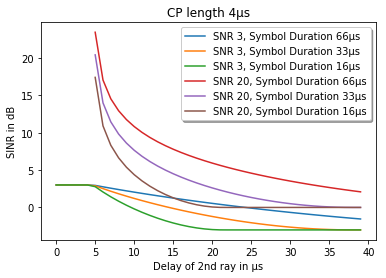

In [71]:
# all time duration in µs
CP_length = 4.7
Ea = 1
N_path = 2


mat_df = df.values
# convert the symbol duration in µs
SymbolDuration_list = 1e6*mat_df[1, 0:3]
tau_lists = [np.array([0, x]) for x in range(40)]

Ps_list = np.zeros( ( len(SymbolDuration_list), len(tau_lists) ) )
Pi_list = np.zeros( ( len(SymbolDuration_list), len(tau_lists) ) )

i = -1
for SymbolDuration in SymbolDuration_list:
    i += 1
    j = -1
    for tau in tau_lists:
        j += 1
        Ps, Pi = CalculatePow( SymbolDuration, CP_length, tau, Ea, N_path )
        Ps_list[i][j] = Ps
        Pi_list[i][j] = Pi

# convert SNR in dB to linear scale: low SNR and high SNR 
SigmaRatioDB_list = np.array([3, 20])
# SigmaRatioLinear_list = dB2Linear( SigmaRatioDB_list )

#for SigmaRatioLinear in SigmaRatioLinear_list: 
SINR_list = np.array([], dtype=np.int64).reshape( len(tau_lists) ,0 )
for SigmaRatioDB in SigmaRatioDB_list:
    SigmaRatioLinear =  dB2Linear(SigmaRatioDB)
    a = np.transpose( Linear2dB ( SINR( Ps_list, Pi_list, 1/SigmaRatioLinear ) ) )
    SINR_list = np.hstack([SINR_list, a])

# plot figure 
lineObjects = plt.plot( SINR_list )
label_list = []
for SigmaRatioDB in SigmaRatioDB_list:
    for SymbolDuration in SymbolDuration_list:
        label_list.append( 'SNR ' + str(int(SigmaRatioDB)) + ', Symbol Duration '+ str(int(SymbolDuration)) + 'µs')

plt.legend(iter(lineObjects), label_list, shadow = True, fancybox = True) 
plt.xlabel('Delay of 2nd ray in µs')
plt.ylabel('SINR in dB')
plt.title('CP length ' + str(int(CP_length)) + 'µs')

## Analysis Based on Our Simulation Model

Given the following variables 
- Channel gain characterized by power-delay profile, and SNR
- Symbol duration and the corresponding CP length for the 3 shapes given in the data frame in Introduction

### Multipath Channel Fading Modeling with Tapped Delay
We apply tapped delay line model to represent the impulse response of a multipath channel.
$$h(t, \tau) = \sum_{i = 0}^{N-1} c_i(t) \delta(\tau - \tau_i)$$
Note that the coefficient $c_i(t)$ is time-variant.

The model is implemented following 3GPP TR 36.803 Table B.2.2.1-4 Extended Typical Urban model, with 9 multipath components. The table is given in below.

In [72]:
data = {'Tap delay in µs' : pd.Series([0, 0.05, 0.12, 0.2, 0.23, 0.5, 1.6, 2.3, 5]),
        'Relative (average) power in dB' : pd.Series([-1.0, -1.0, -1.0, 0.0, 0.0, 0.0, -3.0, -5.0, -7.0])
       }
df_PowProfile = pd.DataFrame(data, columns = ['Tap delay in µs', 'Relative (average) power in dB'])

df_PowProfile

,Tap delay in µs,Relative (average) power in dB
0,0.00,-1.0
1,0.05,-1.0
2,0.12,-1.0
3,0.20,0.0
4,0.23,0.0
5,0.50,0.0
6,1.60,-3.0
7,2.30,-5.0
8,5.00,-7.0


In multipath environment, the received power $r$ has a Rician distribution, whose pdf is given by 
$$P(r) = \frac{r}{\sigma^2}\exp\left(-\frac{r^2+A^2}{2\sigma^2}\right)I_0\left(\frac{rA}{\sigma^2}\right)$$
where $I_0(x)$ is the modified Bessel function of the first kind, zero order.

If there is no LOS, $A = 0$ and we have the pdf as Rayleight distribution:
$$P(r) = \frac{r}{\sigma^2}\exp\left(-\frac{r^2}{2\sigma^2}\right)$$


Since the channel is time-varying, assuming NLOS, each tap can be modeled to have a Rayleigh distribution with a mean value of relative power described in the table above. 

In [73]:
# define function to generate multipath, given tap delay and average power in the above table

def GenerateMultipath( mat_df_PowProfile ):
    # - inputs: array of tap delay in µs and relative average power in dB
    # - outputs: vector of Ea in linear scale
    N_path = mat_df_PowProfile.shape[0]
    meanvalue = mat_df_PowProfile[:,1]
    modevalue = np.sqrt( 2/np.pi ) * dB2Linear( meanvalue )
    # create the multipath tap gain in each tap, with the corresponding average power gain respectively
    s = np.random.rayleigh( modevalue )
    return s

### Estimation of Capacity 
Because the OFDM receiver is assumed to remove the CP and demodulate the data only over the symbol duration, the CP is seen at the system level as the pure overhead. 
$$C' = \frac{SymbolDuration}{SymbolDuration + CP}C$$

Two approaches to estimate capacity $C$ per block: 
- [Approach 1] Assume ideal adaptive modulation and coding (AMC) and a certain degradation fatcor form the Shannon limit $\alpha$, e.g., $\alpha = 2$dB. A symbol is limited to a maximum capacity based on the highest modulation and coding scheme (MCS), e.g., $6$ b/s/Hz for 256-QAM with code rate 3/4. 
- [Approach 2] Consider the mapping from SINR interval to MCS, and then the corresponding symbol error rate.

For simplility we use the first approach.

Note that the amount of data transmitted on each shape is $Capacity [b/s/Hz] * TTI [s] * SCS [Hz]$.

The amount of data transmitted on each PRB is $Capacity [b/s/Hz] * TTI [s] * SCS [Hz/subcarrier] * 12 [subcarrier]$.

In [74]:
# define function to compute capacity on each shape
def CalculateCapacity( SINR_array, SymbolDuration, alpha, CP_length, maxCapacity ):
    C = np.minimum( np.log10( 1 + alpha*SINR_array ), maxCapacity )
    Capacity = (SymbolDuration/(SymbolDuration + CP_length)) * C
    return Capacity

In [75]:
# convert data frame to matrix
mat_df_PowProfile = df_PowProfile.values

#   number of the taps 
N_path = mat_df_PowProfile.shape[0]

# We analyze the SINR (including the ISI and ICI) depending on the SNR for the following 4 shapes:
# - shape 1, 2, and shape 3 with normal or extended CP

# Note that the SNR takes only pathloss gain into account but not the multipath channel gain
SNR_list = np.linspace(5, 20, 30)
tau = mat_df_PowProfile[:, 0]
# number of randomly generated channels
N_GenRand = 5000

SINR_list = np.zeros([len(SNR_list), mat_df.shape[1]])
Capacity_list = np.zeros([len(SNR_list), mat_df.shape[1]])
DataVol_list = np.zeros([len(SNR_list), mat_df.shape[1]])

#  degradation fatcor for Shannon limit
alpha = dB2Linear(2)
# maximum capacity in b/s/hz
maxCapacity = 6
    
# for each shape
i = -1
for idx_shape in range(5):
    i += 1
    # read the symbol duration, CP duration,  and TTI duration in each shape. all convert to µs since tau in µs 
    SubcarrierSpacing = mat_df[0][idx_shape]
    SymbolDuration = 1e6*mat_df[1][idx_shape]
    CP_length = 1e6*mat_df[2][idx_shape]
    TTILength = 1e6*mat_df[7][idx_shape]
    
    # for each SNR
    j = -1
    for SNR in SNR_list:
        j += 1
        SigmaRatioLinear =  dB2Linear(SNR)
        # since each tap follows Rayleigh distribution,  Ps and Pi are weighted sums of the i.i.d. rayleigh distributed rv.s
        # monte carlo
        SINR_collect = np.zeros([N_GenRand, 1])
        for idx_randomGeneration in range( N_GenRand ):
            Ea = GenerateMultipath( mat_df_PowProfile )  
            Ps, Pi = CalculatePow( SymbolDuration, CP_length, tau, Ea, N_path )
            SINR_collect[idx_randomGeneration] =   SINR( Ps, Pi, 1/SigmaRatioLinear )
        AverageSINR = np.mean(SINR_collect)
        # calculate SINR
        SINR_list[j][i] =  AverageSINR
        # calculate capacity on this shape in b/s/Hz
        Capacity_list[j][i] = CalculateCapacity( AverageSINR, SymbolDuration, alpha, CP_length, maxCapacity )
        # Calculate data volume per PRB composed of the shape in b/PRB
        DataVol_list[j][i] = Capacity_list[j][i] * (TTILength*1e-6) * SubcarrierSpacing *12


Text(0,0.5,u'SINR in dB')

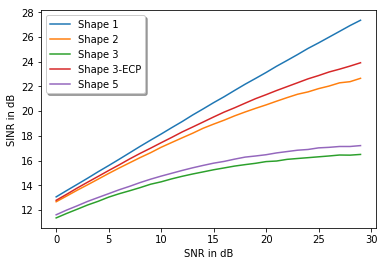

In [76]:
# plot SINR on each shape
lineObjects = plt.plot( Linear2dB(SINR_list) )
label_list = ['Shape 1', 'Shape 2', 'Shape 3', 'Shape 3-ECP', 'Shape 5']
plt.legend(iter(lineObjects), label_list, shadow = True, fancybox = True) 
plt.xlabel('SNR in dB')
plt.ylabel('SINR in dB')

Text(0,0.5,u'Data in b/PRB')

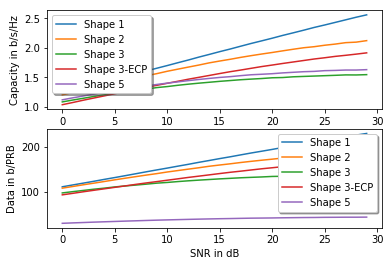

In [77]:
# plot capacity in b/s/Hz on each shape
plt.subplot(2,1,1)
lineObjects = plt.plot( Capacity_list )
label_list = ['Shape 1', 'Shape 2', 'Shape 3', 'Shape 3-ECP', 'Shape 5']
plt.legend(iter(lineObjects), label_list, shadow = True, fancybox = True) 
plt.xlabel('SNR in dB')
plt.ylabel('Capacity in b/s/Hz')


# plot data in bit transmitted on each PRB consisting of each shape 
plt.subplot(2,1,2)
lineObjects = plt.plot( DataVol_list )
label_list = ['Shape 1', 'Shape 2', 'Shape 3', 'Shape 3-ECP', 'Shape 5']
plt.legend(iter(lineObjects), label_list, shadow = True, fancybox = True) 
plt.xlabel('SNR in dB')
plt.ylabel('Data in b/PRB')

In [78]:
np.savetxt("SNR_list.csv", SNR_list, delimiter=",")
np.savetxt("SINR_list.csv", SINR_list, delimiter=",")
np.savetxt("Capacity_list.csv", Capacity_list, delimiter=",")
np.savetxt("DataVol_list.csv", DataVol_list, delimiter=",")